In [1]:
import pandas as pd
import numpy as np
import sys

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("pe_data/pe_users_13_14_15-2018-03-19T18.csv")
data
data2 = pd.read_csv("PE_test_data - Sheet1.csv")
data2



,question_number,contributor_id,taskrun_article_number,answer_number,start_pos,end_pos,source_text_length,question_text
0,1,1,1,2,150,235,1500,NaN
1,1,2,1,2,150,235,1500,NaN
2,1,3,1,2,150,235,1500,NaN
3,2,1,1,1,150,235,1500,NaN
4,2,2,1,1,150,235,1500,NaN
5,2,3,1,1,150,235,1500,NaN
6,2,4,1,1,150,235,1500,NaN
7,2,5,1,1,150,235,1500,NaN
8,3,1,1,3,150,235,1500,NaN
9,3,2,1,3,150,235,1500,NaN


In [3]:
def data_storer(data):
    article_nums = np.unique(data['taskrun_article_number'])
    dict_of_article_df = dict()
    for i in article_nums:
        article =data[data['taskrun_article_number'] == i]
        question_nums = np.unique(article['question_number'])
        new_dict = dict()
        for x in question_nums:
            array = []
            array.append(article.loc[article['question_number']== x, 'question_text'][0:1])
            
            answers = [article.loc[article['question_number']== x, 'answer_number']]
            answers.append([article.loc[article['question_number']== x, 'contributor_id']])
            answers.append([article.loc[article['question_number']== x, 'start_pos']])
            answers.append([article.loc[article['question_number']== x, 'end_pos']])
            answers.append([article.loc[article['question_number']== x, 'source_text_length']])
            array.append(answers)

            new_dict[x] = array
            #this is where krippendorf goes
        dict_of_article_df[i] = new_dict
    return dict_of_article_df

In [4]:
data1 = data_storer(data2)


In [5]:
data1[3][1][1]

KeyError: 1

In [6]:
def get_question_text(data,article_num, question_num):
    return data[article_num][question_num][0]

In [7]:
def get_question_answers(data, article_num, question_num):
    return data[article_num][question_num][1][0]

In [8]:
def get_question_userid(data, article_num, question_num):
    return data[article_num][question_num][1][1][0]

In [9]:
def get_question_start(data, article_num, question_num):
    return data[article_num][question_num][1][2][0]

In [10]:
def get_question_end(data, article_num, question_num):
    return data[article_num][question_num][1][3][0]

In [11]:
def get_text_length(data, article_num, question_num):
    return data[article_num][question_num][1][4][0]

In [12]:
def cleanForUnitization(data, article_num, question_num):
    returnDict = dict()
    returnDict['Offsets'] = get_question_start(data, article_num,question_num).tolist()
    returnDict['Ends'] = get_question_end(data, article_num, question_num).tolist()
    returnDict['Categories'] = get_question_answers(data, article_num, question_num).tolist()
    returnDict['Raters'] = get_question_userid(data, article_num, question_num).tolist()
    return returnDict

In [13]:
def get_num_users(data, article_num, question_num):
    return len(np.unique(get_question_userid(data, article_num, question_num)))

In [14]:
def get_user_tuples(data, article_num, question_num):
    returnDict = dict()
    users = get_question_userid(data, article_num, question_num).tolist()
    starts = get_question_start(data, article_num, question_num).tolist()
    ends = get_question_end(data, article_num, question_num).tolist()
    index = 0
    for u in users:
        returnDict[u] = (starts[index], ends[index])
        index+= 1
    return returnDict

In [15]:
def get_user_arrays(data, article_num, question_num):
    returnDict = dict()
    users = get_question_userid(data, article_num, question_num)
    answers = get_question_answers(data, article_num, question_num).tolist()
    index = 0
    for u in users:
        array = np.zeros(max(answers))
        array[answers[index]-1] = 1
        returnDict[u] = array
        index +=1
    return returnDict

    

In [16]:
def get_question_answer_ratios(dictionary):
    users_num = len(dictionary.keys())
    returnArray = np.zeros(len(list(dictionary.values())[0]))
    for a in dictionary.values():
        returnArray = returnArray + a
    return (returnArray/users_num).tolist()

In [23]:
def find_agreement_scores_u(data, article_num, question_num):
    user_array_dict = get_user_arrays(data, article_num, question_num)
    ans_ratio = get_question_answer_ratios(user_array_dict)
    num_users = get_num_users(data,article_num, question_num)
    grade = test_threshold_matrix(ans_ratio, num_users)
    if grade == 'L':
        print("agreement too low")
        return 
    elif grade == 'M':
        print("return to sender")
        return
    else:
        return find_starts_ends_of_winner(data,article_num,question_num,user_array_dict, ans_ratio)
    

In [31]:
find_agreement_scores_c(data1, 1 ,3)

{1: array([0., 0., 1.]),
 2: array([0., 0., 1.]),
 3: array([0., 0., 1.]),
 4: array([0., 0., 1.]),
 5: array([0., 0., 1.]),
 6: array([0., 0., 1.]),
 7: array([0., 0., 1.]),
 8: array([0., 0., 1.]),
 9: array([0., 0., 1.]),
 10: array([0., 0., 1.])}

In [30]:
def find_agreement_scores_c(data, article_num, question_num):
    user_array_dict = get_user_arrays(data, article_num, question_num)
    ans_ratio = get_question_answer_ratios(user_array_dict)
    num_users = get_num_users(data,article_num, question_num)
    grade = test_threshold_matrix(ans_ratio, num_users)
    if grade == 'L':
        print("agreement too low")
        return 
    elif grade == 'M':
        print("return to sender")
        return
    else:
        index = ans_ratio.index(max(ans_ratio))
        for k in user_array_dict.keys():
            if user_array_dict[k][index] == 0:
                del user_array_dict[k]
        return user_array_dict

In [75]:
a = get_user_arrays(data1, 1, 3)
a



{1: array([0., 0., 1.]),
 2: array([0., 0., 1.]),
 3: array([0., 0., 1.]),
 4: array([0., 0., 1.]),
 5: array([0., 0., 1.]),
 6: array([0., 0., 1.]),
 7: array([0., 0., 1.]),
 8: array([0., 0., 1.]),
 9: array([0., 0., 1.]),
 10: array([0., 0., 1.])}

In [76]:
b = get_question_answer_ratios(a)
b

[0.0, 0.0, 1.0]

In [77]:
test_dict = cleanForUnitization(data1, 1, 3)
type(test_dict['Categories'][0])

int

In [18]:
def test_threshold_matrix(array, num_of_users):
    grade = "L"
    return_array = []
    index = 0
    for i in array:
        if num_of_users <= 2:
            print("Not enough users")
            break
        if num_of_users == 3:
            if (i > 2/3):
                grade = "H"
        if num_of_users == 4:
            if (i > 1/4 and i < 3/4):
                grade = "M"
            elif (i >= 3/4):
                grade = "H"
        if num_of_users == 5:
            if i > 2/5 and i <4/5:
                grade = "M"
            elif (i >= 4/5):
                grade = "H"
        if num_of_users == 6:
            if i > 2/6 and i < 4/6:
                grade = "M"
            elif i >= 4/6:
                grade = "H"
        if num_of_users == 7:
            if i > 3/7 and i < 5/7:
                grade = "M"
            elif i >= 5/7:
                grade = "H"
        if num_of_users == 8:
            if i > 3/8 and i < 6/8:
                grade = "M"
            elif i >= 6/8:
                grade = "H"
        if num_of_users == 9:
            if i > 4/9 and i < 7/9:
                grade = "M"
            elif i >= 7/9:
                grade = "H"
        if num_of_users == 10:
            if i > 5/9 and i < 8/10:
                grade = "M"
            elif i >= 8/10:
                grade = "H"
        if grade == "H":
            return "H"
        else:
            index += 1
            return_array.append(grade)
            
    if "M" in return_array: 
        return "M"
    else:
        return "L"

In [79]:
test_threshold_matrix(b, 3)

'H'

In [80]:
get_user_tuples(data1, 1, 3)

{1: (150, 235),
 2: (150, 235),
 3: (150, 235),
 4: (150, 235),
 5: (150, 235),
 6: (150, 235),
 7: (150, 235),
 8: (150, 235),
 9: (150, 235),
 10: (150, 235)}

In [19]:
def find_starts_ends_of_winner(data, article_num, question_num, user_arrays, answer_ratio_array):
    user_start_end = get_user_tuples(data, article_num, question_num)
    winner_pos = answer_ratio_array.index(max(answer_ratio_array))
    for k in user_arrays.keys():
        if user_arrays[k][winner_pos] == 0:
            del user_start_end[k]
    return user_start_end

In [82]:
find_starts_ends_of_winner(data1, 1, 3, a, b)

{1: (150, 235),
 2: (150, 235),
 3: (150, 235),
 4: (150, 235),
 5: (150, 235),
 6: (150, 235),
 7: (150, 235),
 8: (150, 235),
 9: (150, 235),
 10: (150, 235)}

## 1. Function that takes in raw data and splits by article number into a dict of DF.
2. Function that takes in DF of 1 article and outputs a dict

In [140]:
dataTemp = data_storer(data2)
get_question_answers(dataTemp, 1722, 3)

1      2
32     1
33     1
34     1
35     1
36     1
37     1
38     1
39     1
40     1
41     1
42     1
43     1
44     1
45     1
46     1
47     1
48     1
49     1
50     1
51     1
98     1
118    1
119    1
120    1
121    1
122    1
123    1
124    1
125    1
126    1
151    1
152    1
Name: answer_number, dtype: int64

In [23]:
data3 = pd.read_csv("question_scores.csv")
data3

,Article Number,Question Number,Agreed Answer,Agreement Score
0,1729,1,2,0.5750000000000001
1,1729,5,1,0.4
2,1729,6,1,0.6666666666666666
3,1729,6,2,0.6666666666666666
4,1729,6,4,0.6666666666666666
5,1729,6,5,0.6666666666666666
6,1729,6,7,0.6666666666666666
7,1729,8,1,0.0
8,1729,9,1,NaN
9,1729,10,2,NaN


In [24]:
np.count_nonzero(data3['Agreement Score'])

290

In [37]:
data3

,Article Number,Question Number,Agreed Answer,Agreement Score
0,1729,1,2,0.5750000000000001
1,1729,5,1,0.4
2,1729,6,1,0.6666666666666666
3,1729,6,2,0.6666666666666666
4,1729,6,4,0.6666666666666666
5,1729,6,5,0.6666666666666666
6,1729,6,7,0.6666666666666666
7,1729,8,1,0.0
8,1729,9,1,NaN
9,1729,10,2,NaN


In [69]:
data4 = data3[data3['Agreement Score'] != "2Short loozerz"].dropna().astype('float64')


## data3['Agreement Score'].dropna().hist()
plt.show()

In [70]:
ord_data = data4[data4['Question Number'].isin([1, 8, 9, 12, 13])]
nom_data =  data4[data4['Question Number'].isin([5,10])]
int_data =  data4[data4['Question Number'].isin([7,11])]
mult_data =  data4[data4['Question Number'].isin([6])]

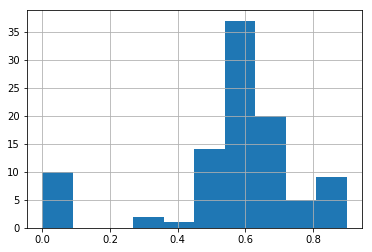

In [74]:
ord_data['Agreement Score'].hist()

plt.show()

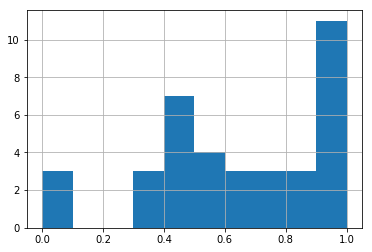

In [75]:
nom_data['Agreement Score'].hist()
plt.show()

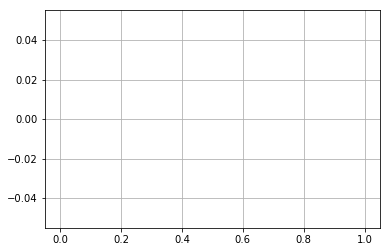

In [76]:
int_data['Agreement Score'].hist()
plt.show()

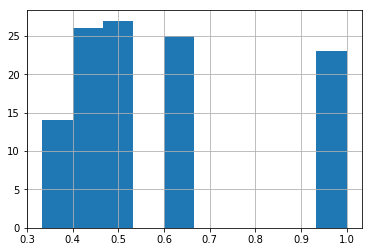

In [77]:
mult_data['Agreement Score'].hist()
plt.show()